# D-Waveマシンを用いた語義曖昧性の解消

## 文献情報

* タイトル: A Quadratic 0-1 Programming Approach for
Word Sense Disambiguation
* 著者: Boliang Lin
* 書誌情報: arXiv:2201.04877
* DOI: 
https://doi.org/10.48550/arXiv.2201.04877

## 概要

### 語義曖昧性の解消とは

日本語の「高い」には、複数の語義が存在します。以下の例文を見て下さい。
* 都会のマンション価格はとても<u>高い</u>。
* 蛍光灯は<u>高い</u>場所にある。

1文目の「高い」は「価値がある」という意味です。一方、2文目の「高い」は「物理的に上にある」という意味です。このように、文中の単語がどの語義を表しているのか判断する過程のことを、「語義曖昧性の解消(Word Sense Disambiguation, WSD)」と言います。従来、WSDには教師あり学習が主に用いられて来ました。その手法では、隣接する単語の関係性のみを考慮して語義の判定を行っていました。しかし、単語の語義は文脈中すべての単語とその語義に影響されると考えられます。そこで、[この論文](https://doi.org/10.48550/arXiv.2201.04877)では、文脈中すべての単語間、語義間の関係性を考慮した2次0-1整数計画モデルを提案しています。そして、そのモデルを本記事の担当者がD-Waveマシンで解いた結果を紹介します。

## 方法

まずは、論文で紹介されている2次0-1整数計画モデルについて説明します。

### 目的関数(第1項)

|  | &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; | 説明 |
| :---: | :---: | :---: |
| **変数** | $x_{ik} \in \{0, 1\}$ | $i$番目の単語が$k$番目の語義を選ぶ時に$1$ |
|　**定数** | $w_{i}$ | $i$番目の単語 |
|　 | $s_{ik}$ | $i$番目の単語の$k$番目の語義 |
|　 | $c_{ik}$ | $w_i, s_{ik}$間の$\cos$類似度 |

<img src="figures/fig1.png" width="25%">

#### $\cos$類似度とは

ここで、$\cos$類似度について説明します。

ある2つの単語を$\mathbf{a},\mathbf{b}$というベクトルで表したとき、内積の公式( $\mathbf{a}・\mathbf{b}=|\mathbf{a}||\mathbf{b}|\cos\theta$ )を変形すると、$\cos\theta$$=\mathbf{a}・\mathbf{b}/|\mathbf{a}||\mathbf{b}|$となります。これを$\cos$類似度と呼び、1に近いほど2つの単語が類似していることを表します。

$c_{ik}$を用いて、目的関数(第1項)を次のように定義します。



$$
Z_1(X)=-\sum_{i} \sum_{k} c_{i k} x_{i k}
$$

これは、各単語の$\cos$類似度が最も高い語義が選ばれるようにするための項です。

### 目的関数(第2項)

$\cos$類似度が最も高い語義が正解の語義とは限りません。そこで、文脈中の他の単語との関係性を表す$r_{iu,jv}$を定義します。

$$
r_{i m, j n}:=\lambda_{1}\left(b_{i, j n}+b_{j, i m}\right)+\lambda_{2} h_{i m, j n}+\lambda_{3}\left(c_{i m}+e_{w_{i} w_{j}}+c_{j n}\right)
$$

<img src="figures/fig2.png" width="50%">

>(引用) [https://arxiv.org/abs/2201.04877](https://arxiv.org/abs/2201.04877)

$r$の値が大きいほど、両者の関係は良いという意味になります。

パラメータの説明は次の通りです。

| &emsp;定数&emsp;&emsp;  | 説明 |
| :---: | :---: |
| $r_{iu,jv}$ | $w_i, w_j$間、$s_{iu}, s_{jv}$間の関係性 |
| $\lambda_1, \lambda_2, \lambda_3$ | 各項の重み |
| $b_{i, jn}$ | $w_i$と$s_{jn}$間の$\cos$類似度 |
| $h_{im, jn}$ | $s_{im}$と$s_{jn}$間の$\cos$類似度 |
| $e_{wi, wj}$ | $w_i$と$w_j$間の$\cos$類似度 |

$r_{iu,jv}$を定義することで、文脈に合った語義を選べるようになります。目的関数(第2項)は次のようになります。

**目的関数(第2項)**

$$
Z_2(X) = -\sum_{i, j} \sum_{u} \sum_{v} r_{i u, j v} x_{i u} x_{j v}
$$

### $r_{iu,jv}$のイメージ

$r_{iu,jv}$について、補足して説明します。

* <u>都会</u> の <u>マンション</u> <u>価格</u> は <u>とても</u> <u>高い</u>。

| 単語  |            | 語義     |                              | cos類似度|  |
| :---:| :---: | :---: |:---:|:---:| --- |
| $w_0$ | 都会       | $s_{00}$ | 人が多く住む土地             |$c_{00}=$| 0.9 |
| $w_1$ | マンション | $s_{10}$ | 中高層の集合住宅             |$c_{10}=$ | 0.9 |
| $w_2$ | 価格       | $s_{20}$ | 商品の価値を表す            |$c_{20}=$ | 0.9 |
| $w_3$ | とても     | $s_{30}$ |  程度のはなはだしいさま      |$c_{30}=$ | 0.9 |
| $w_4$ | 高い       | $s_{40}$ | 物が上の位置にあること       |$c_{40}=$| 0.6 |
|       |            | $s_{41}$ | 金額がかさむさま             |$c_{41}=$ | 0.3 |

上記の例文において、「$w_4$: 高い」の正しい語義は「$s_{41}$: 金額がかさむさま」です。しかし、表の$\cos$類似度が最も大きい語義は「$s_{40}$: 物が上の位置にあること」であるため、目的関数(第1項)だけでは正しい語義が選ばれません。そこで、第2項を定義します。文脈中の「$w_{1}$: マンション」「$w_{2}$: 価格」と、より相性の良い「$w_{4}$: 高い」の語義は「$s_{41}$: 金額がかさむさま」だと考えられます。よって、$r_{41, jv}$の値は大きくなり、正しい語義が選択されます。

### 目的関数(第1項+第2項+制約項)

これより、最適化したい目的関数は次のようになります。

$$
\operatorname{Min} Z(X)=- \alpha \sum_{i} \sum_{k} c_{i k} x_{i k}-\beta \sum_{i, j} \sum_{u} \sum_{v} r_{i u, j v} x_{i u} x_{j v}+\gamma \sum_{i}\left(\sum_{k} x_{i k}-1\right)^{2}
$$

ここで、$\alpha, \beta, \gamma$はハイパーパラメータ、第3項は各単語に1つの語義が選ばれるようにする制約項です。

この目的関数をD-Waveマシンで解いていきましょう。

## 実験

### ライブラリのインストール

必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install dwave-ocean-sdk
!pip install openjij
!pip install pyqubo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import wordnet as wn
from gensim.models import KeyedVectors
from pyqubo import Array, Constraint, Placeholder, Binary

### 語義曖昧性を解消する文章

まずは、語義曖昧性のある文章を定義します。使用するデータセットは、[SENSEVAL-2](https://web.eecs.umich.edu/~mihalcea/senseval/index.html)の一部です。このデータセットには、英文と単語に対する正解の語義が含まれています。

今回の実験で対象とする文章は、次の英文です。

>「The art of change-ringing is peculiar to the English, and, like most English peculiarities, unintelligible to the rest of the world.」

英文から対象となる単語を抽出します。

In [ ]:
words = [
    "art",
    "change_ringing",
    "peculiar",
    "english",
    "most",
    "english",
    "peculiarity",
    "unintelligible",
    "rest",
    "world",
]

語義は、[WordNet](http://wordnetweb.princeton.edu/perl/webwn?s=refer&sub=Search+WordNet&o2=1&o0=1&o8=1&o1=1&o7=1&o5=1&o9=&o6=1&o3=1&o4=1&h=0000000) のものを使用します。WordNetは英語の概念辞書であり、各語義にIDが付けられています。各単語に対する正解の語義のIDは次の通りです。複数の正解が存在する単語もあります。

In [ ]:
correct_keys = {
    0: ["art%1:09:00::"],
    1: ["change_ringing%1:04:00::"],
    2: ["peculiar%5:00:00:specific:00", "peculiar%5:00:00:characteristic:00"],
    3: ["english%1:18:00::"],
    4: ["most%3:00:02::"],
    5: ["english%3:01:00::"],
    6: ["peculiarity%1:07:02::", "peculiarity%1:09:00::"],
    7: ["unintelligible%5:00:00:incomprehensible:00"],
    8: ["rest%1:24:00::"],
    9: ["world%1:14:02::"],
}

In [ ]:
# WordNetのダウンロード
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shikanai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shikanai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/shikanai/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shikanai/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# 単語に関するデータ
word_data = {}
for i, word in enumerate(words):
    word_data[i] = {"word": word}

In [ ]:
# 語義に関するデータ
sense_data = {}
for i, word in enumerate(words):
    # 定義文の追加
    for k, synset in enumerate(wn.synsets(word)):
        sense_data[(i, k)] = {"sense": synset.definition()}

    word_data[i]["num_sense"] = k + 1

    # 語義キーの追加
    for k, synset in enumerate(wn.lemmas(word)):
        if synset.key() in correct_keys[i]:
            sense_data[(i, k)]["key"] = synset.key()
            sense_data[(i, k)]["correct"] = "*"
        else:
            sense_data[(i, k)]["key"] = synset.key()
            sense_data[(i, k)]["correct"] = ""

IDに紐付けられている語義を表示させてみましょう。正解の語義には、「*」を付けています 。

In [ ]:
df = pd.DataFrame.from_dict(sense_data, orient="index")

In [ ]:
df.head()

sense  \
0 0  the products of human creativity; works of art...   
  1    the creation of beautiful or significant things   
  2  a superior skill that you can learn by study a...   
  3  photographs or other visual representations in...   
1 0  ringing tuned bells in a fixed order that is c...   

                          key correct  
0 0             art%1:06:00::          
  1             art%1:04:00::          
  2             art%1:09:00::       *  
  3             art%1:10:00::          
1 0  change_ringing%1:04:00::       *

### 単語ベクトルの獲得

単語-語義間の$\cos$類似度を求めるために、各単語をベクトル化する必要があります。

本実験では、Wikipediaを学習したモデルを使用します。このモデルでは、単語を100次元のベクトルに変換しています。詳しくは下記をご覧ください。
>  [Wikipedia2Vec](https://wikipedia2vec.github.io/wikipedia2vec/)

In [ ]:
# 学習モデルのダウンロード(時間がかかります)
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2
# ファイルの解凍
!bzip2 -d enwiki_20180420_100d.txt.bz2

zsh:1: command not found: wget
bzip2: Can't open input file enwiki_20180420_100d.txt.bz2: No such file or directory.


In [ ]:
# モデルの読み込み(時間がかかります)
wikimodel = KeyedVectors.load_word2vec_format("enwiki_20180420_100d.txt", binary=False)

ここで、対象単語である「art」の単語ベクトルを表示させて見ましょう。

In [ ]:
wikimodel["art"][:10]

array([-0.1255, -0.1265, -0.3414, -0.0495, -0.4867, -0.4012,  0.025 ,
        0.0366, -0.3346, -0.213 ], dtype=float32)

モデルに含まれていない単語(本実験では「change_ringing」)もあるので、その場合は次のようにベクトルの足し算で作成します。

In [ ]:
# ベクトルの合成
wikimodel["change_ringing"] = wikimodel["change"] + wikimodel["ringing"]

for i, word in enumerate(words):
    word_data[i]["vector"] = wikimodel[word]

### 語義ベクトルの獲得

これで、単語ベクトルを獲得することが出来ました。この単語ベクトルを利用して、語義ベクトルを作成していきます。作成の手順は次の通りです。

> 1. 語義の定義文から、名詞，動詞，形容詞，副詞を抽出する。(これらを内容語と呼ぶ)
2. 単語と内容語のcos類似度を計算して、閾値$\delta$以上の内容語を候補集合に加える
3. 候補集合にある内容語の単語ベクトルの平均を語義ベクトルとする
>
>[分散表現に基づく日本語語義曖昧性解消における
辞書定義文の有効性](https://www.anlp.jp/proceedings/annual_meeting/2016/pdf_dir/P11-1.pdf)

<img src="figures/fig3.png" width="100%">

上記の手順通りに語義ベクトルを作成していきます。

In [ ]:
# cos類似度を計算
def cos_similarity(vec1, vec2):
    result = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return result

In [ ]:
# 語義ベクトルの作成
def sense2vec(parts, delta, w_data=word_data, s_data=sense_data):
    """
    parts: 内容語とする品詞
    delta: 閾値
    """
    for i, k in s_data.keys():
        morph = nltk.word_tokenize(s_data[i, k]["sense"])  # 文を単語に分割
        pos = nltk.pos_tag(morph)  # 単語の品詞を取得

        sum_vec = count = 0
        for p in pos:
            part_of_word = p[0]  # 内容語
            part_of_speech = p[1][0]  # 内容語の品詞

            if (
                (part_of_speech in parts)
                and (part_of_word in wikimodel)
                and (
                    cos_similarity(w_data[i]["vector"], wikimodel[part_of_word]) > delta
                )
            ):
                sum_vec += wikimodel[p[0]]
                count += 1

        sense_vec = sum_vec / count
        s_data[i, k]["vector"] = sense_vec

    return s_data

準備が終わったので、語義ベクトルを作成しましょう。

In [ ]:
parts = ["J", "N", "R", "V"]
sense_data = sense2vec(parts=parts, delta=0)

### $c_{ik}$の作成

ここでは、第1項の定数$c_{ik}$を作成します。これは、$i$番目の単語に対する$k$番目の語義との間のcos類似度を表します。

In [ ]:
def create_c(w_data=word_data, s_data=sense_data):
    c = {}
    for i, k in s_data.keys():
        c[i, k] = cos_similarity(w_data[i]["vector"], s_data[i, k]["vector"])
        s_data[i, k]["cos"] = round(c[i, k], 2)

    return c, s_data

In [ ]:
cos, sense_data = create_c()

結果を表示してみましょう。

In [ ]:
df = pd.DataFrame.from_dict(
    sense_data, orient="index", columns=["sense", "correct", "cos"]
)

In [ ]:
df.head()

sense correct   cos
0 0  the products of human creativity; works of art...          0.71
  1    the creation of beautiful or significant things          0.51
  2  a superior skill that you can learn by study a...       *  0.46
  3  photographs or other visual representations in...          0.65
1 0  ringing tuned bells in a fixed order that is c...       *  0.82

これで、cos類似度の最も高い語義が正解の語義とは限らないことが分かりました。

### $r_{im, jn}$の作成

続いて、第2項の定数$r_{im,jn}$を作成します。

**まずは、**$b_{i, jn}, h_{im, jn}, c_{im}$を作成し、最後に足し合わせて$r_{im, jn}$を作成していきましょう。

#### $b_{i, jn}$(単語-語義のcos類似度)の作成

In [ ]:
def create_b(w_data=word_data, s_data=sense_data):
    b = {
        (i, j, n): cos_similarity(w_data[i]["vector"], s_data[j, n]["vector"])
        for i in w_data.keys()
        for j, n in s_data.keys()
    }
    return b

#### $h_{im,jn}$(語義-語義のcos類似度)の作成

In [ ]:
def create_h(w_data=word_data, s_data=sense_data):
    h = {
        (i, m, j, n): cos_similarity(s_data[i, m]["vector"], s_data[j, n]["vector"])
        for i, m in s_data.keys()
        for j, n in s_data.keys()
    }
    return h

#### $e_{i, j}$(単語-単語のcos類似度)の作成

In [ ]:
def create_e(w_data=word_data, s_data=sense_data):
    e = {
        (i, j): cos_similarity(w_data[i]["vector"], w_data[j]["vector"])
        for i in w_data.keys()
        for j in w_data.keys()
    }
    return e

これまで作成した定数を使って、$r_{im, jn}$を作成しましょう。


$$
r_{i m, j n}:=\lambda_{1}\left(b_{i, j n}+b_{j, i m}\right)+\lambda_{2} h_{i m, j n}+\lambda_{3}\left(c_{i m}+e_{w_{i} w_{j}}+c_{j n}\right)
$$


In [ ]:
def create_r(lam1, lam2, lam3, c=cos):
    b = create_b()
    h = create_h()
    e = create_e()

    # 値が大きくなりすぎないように正規化を行っている
    norm = lam1 * 2 + lam2 * 1 + lam3 * 3  # rの最大値

    r = {
        (i, m, j, n): (
            lam1 * (b[i, j, n] + b[j, i, m])
            + lam2 * h[i, m, j, n]
            + lam3 * (c[i, m] + e[i, j] + c[j, n])
        )
        / norm
        for i, m, j, n in h.keys()
    }
    return r

In [ ]:
rel = create_r(lam1=1.0, lam2=1.0, lam3=1.0)

### 最適化

ここからは最適化を行います。

**目的関数**

$$
\operatorname{Min} Z(X)=- \alpha \sum_{i} \sum_{k} c_{i k} x_{i k}-\beta \sum_{i, j} \sum_{m} \sum_{n} r_{i m, j n} x_{i m} x_{j n}+\gamma \sum_{i}\left(\sum_{k} x_{i k}-1\right)^{2}
$$

In [ ]:
def formulation(w_data=word_data, s_data=sense_data, c=cos, r=rel):
    # バイナリ変数の作成
    x = {(i, k): Binary(f"x[{i}][{k}]") for i, k in s_data.keys()}

    # 目的関数の第1項
    H1 = np.sum([c[i, k] * x[i, k] for i, k in c.keys()])

    # 目的関数の第2項
    H2 = np.sum([r[i, u, j, v] * x[i, u] * x[j, v] for i, u, j, v in r.keys()])

    # 目的関数の第3項
    H3 = np.sum(
        [
            (np.sum([x[i, k] for k in range(w_data[i]["num_sense"])]) - 1) ** 2
            for i in w_data.keys()
        ]
    )

    # 最小化したい目的関数
    H = (
        -Placeholder("alpha") * H1
        - Placeholder("beta") * H2
        + Placeholder("gamma") * Constraint(H3, "H3")
    )
    model = H.compile()

    return model

ここで、サンプラーの設定をします。

In [ ]:
# SAの場合
# from neal import SimulatedAnnealingSampler
# sampler = SimulatedAnnealingSampler()

# D-Waveマシンの場合
# from dwave.system import DWaveCliqueSampler
# sampler_config = {'solver': 'Advantage_system4.1', 'token': 'YOUR_TOKEN'}
# sampler = DWaveCliqueSampler(**sampler_config)

# Opnejijの場合
import openjij as oj

sampler = oj.SQASampler()

全ての設定が終わりました。アニーリングを実行しましょう。

In [ ]:
# 制約を満たしている解を取り出す
def extract_feasible_samples(decoded_samples, print_broken=False):
    feasible_samples = []
    for sample in decoded_samples:
        constraints = sample.constraints(only_broken=True)

        if len(constraints) == 0:
            feasible_samples.append(sample)
        elif print_broken:
            print(constraints)

    return feasible_samples

In [ ]:
# 最適化実行
def optimization(alpha, beta, gamma, num_reads):
    model = formulation()

    feed_dict = {"alpha": alpha, "beta": beta, "gamma": gamma}  # 制約項の係数
    qubo, offset = model.to_qubo(feed_dict=feed_dict)

    sampleset = sampler.sample_qubo(qubo, num_reads=num_reads)

    decoded_samples = model.decode_sampleset(sampleset.aggregate(), feed_dict)
    feasible_samples = extract_feasible_samples(decoded_samples)

    return feasible_samples

In [ ]:
feasible_samples = optimization(alpha=1.0, beta=1.0, gamma=30.0, num_reads=1000)
print("実行可能解:", len(feasible_samples))

実行可能解: 104


各語義がどのくらい解として出力されたのかを確率で表示してみましょう。確率最大の語義には「*」を付けています。

In [ ]:
def output_prob(feasible_samples, w_data=word_data, s_data=sense_data):
    # 確率の計算
    for i, k in s_data.keys():
        s_data[i, k]["prob(%)"] = 0

        for sample_info in feasible_samples:
            if sample_info.sample[f"x[{i}][{k}]"] == 1:
                s_data[i, k]["prob(%)"] += 1 / len(feasible_samples) * 100

    # 確率が1番高い語義を記録
    for i in w_data.keys():
        max_prob = 0

        for k in range(w_data[i]["num_sense"]):
            s_data[i, k]["prob(%)"] = round(s_data[i, k]["prob(%)"], 1)
            s_data[i, k]["max"] = ""

            if max_prob < s_data[i, k]["prob(%)"]:
                max_index = (i, k)
                max_prob = s_data[i, k]["prob(%)"]

        s_data[max_index]["max"] = "*"

    return s_data

In [ ]:
sense_data = output_prob(feasible_samples=feasible_samples)
df = pd.DataFrame.from_dict(
    sense_data, orient="index", columns=["sense", "correct", "prob(%)", "max", "cos"]
)

結果を見てみましょう。

In [ ]:
df.head()

sense correct  prob(%) max  \
0 0  the products of human creativity; works of art...             25.0       
  1    the creation of beautiful or significant things             21.2       
  2  a superior skill that you can learn by study a...       *     21.2       
  3  photographs or other visual representations in...             32.7   *   
1 0  ringing tuned bells in a fixed order that is c...       *    100.0   *   

      cos  
0 0  0.71  
  1  0.51  
  2  0.46  
  3  0.65  
1 0  0.82

In [ ]:
def count_correct(s_data):
    count = 0
    for i, k in s_data.keys():
        if s_data[i, k]["correct"] == "*" and s_data[i, k]["max"] == "*":
            count += 1

    return count

In [ ]:
print("単語の数:", len(word_data))
print("正解数:", count_correct(s_data=sense_data))

単語の数: 10
正解数: 2


以上の結果から、正解率は低く、cos類似度の高い語義が選択されやすいことが分かりました。これらの原因は、目的関数(第１項)のハイパーパラメータが大き過ぎることにあると考えられます。そこで、ここからはハイパーパラメータを調整することで、より良い結果が得られるか検証していきます。最適なハイパーパラメータの探索には、「optuna」を使用します。

### パラメータの探索

In [ ]:
def count_correct_per_sample(
    lam1, lam2, lam3, alpha, beta, gamma, num_reads=1000, s_data=sense_data
):
    """
    6個のハイパーパラメータを入力とし、1サンプル当たりの正解数を返す関数
    """
    r = create_r(lam1=lam1, lam2=lam2, lam3=lam3)
    feasible_samples = optimization(
        alpha=alpha, beta=beta, gamma=gamma, num_reads=num_reads
    )

    if len(feasible_samples) == 0:
        return 0

    count_list = []
    for sample_info in feasible_samples:
        count = 0
        for i, k in s_data.keys():
            if (sample_info.sample[f"x[{i}][{k}]"] == 1) and (
                s_data[i, k]["correct"] == "*"
            ):
                count += 1

        count_list.append(count)

    return np.average(count_list)

In [ ]:
def objective(trial):
    param = {
        # rのハイパーパラメータ
        "lam1": trial.suggest_float("lam1", 0, 30, step=0.1),
        "lam2": trial.suggest_float("lam2", 0, 30, step=0.1),
        "lam3": trial.suggest_float("lam3", 0, 30, step=0.1),
        # 目的関数のハイパーパラメータ
        "alpha": trial.suggest_float("alpha", 0, 30, step=0.1),
        "beta": trial.suggest_float("beta", 0, 30, step=0.1),
        "gamma": trial.suggest_int("gamma", 30, 100),
    }

    return count_correct_per_sample(
        lam1=param["lam1"],
        lam2=param["lam2"],
        lam3=param["lam3"],
        alpha=param["alpha"],
        beta=param["beta"],
        gamma=param["gamma"],
    )

準備が完了しました。ハイパーパラメータの最適化を行いましょう。

In [ ]:
!pip install optuna

In [ ]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

ハイパーパラメータの調整が上手く出来ていることを確認してみましょう。

In [ ]:
def show_graph(study):
    epoches = []
    values = []
    best = 0
    for i in study.trials:
        if best < i.value:
            best = i.value
        epoches.append(i.number + 1)
        values.append(best)

    plt.plot(epoches, values, color="red")
    plt.title("optuna")
    plt.xlabel("trial")
    plt.ylabel("num_correct / sample")
    plt.show()

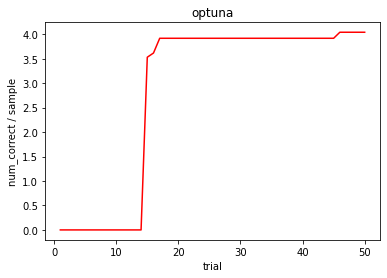

In [ ]:
show_graph(study)

最適なハイパーパラメータは、次のように確かめられます。

In [ ]:
print(study.best_params)

{'lam1': 20.5, 'lam2': 1.9000000000000001, 'lam3': 12.3, 'alpha': 14.9, 'beta': 0.0, 'gamma': 80}


このパラメータでもう一度、アニーリングしてみましょう。

In [ ]:
rel = create_r(
    lam1=study.best_params["lam1"],
    lam2=study.best_params["lam2"],
    lam3=study.best_params["lam3"],
)

feasible_samples = optimization(
    alpha=study.best_params["alpha"],
    beta=study.best_params["beta"],
    gamma=study.best_params["gamma"],
    num_reads=1000,
)
print("実行可能解の数:", len(feasible_samples))

実行可能解の数: 20


結果を表示します。

In [ ]:
sense_data = output_prob(feasible_samples=feasible_samples)
df = pd.DataFrame.from_dict(
    sense_data, orient="index", columns=["sense", "correct", "prob(%)", "max", "cos"]
)

In [ ]:
df.head()

sense correct  prob(%) max  \
0 0  the products of human creativity; works of art...             15.0       
  1    the creation of beautiful or significant things             20.0       
  2  a superior skill that you can learn by study a...       *     10.0       
  3  photographs or other visual representations in...             55.0   *   
1 0  ringing tuned bells in a fixed order that is c...       *    100.0   *   

      cos  
0 0  0.71  
  1  0.51  
  2  0.46  
  3  0.65  
1 0  0.82

In [ ]:
print("単語の数:", len(word_data))
print("正解数:", count_correct(s_data=sense_data))
print("")

単語の数: 10
正解数: 3



ハイパーパラメータを調整した結果、正解数は1つ増えました。しかし、正解率は依然低いままでした。

### Gurobiで解く

Gurobiを使って、厳密解を求めてみます。ハイパーパラメータは、「optuna」で求めた最適なものを使用します。また、以下のコードは、ローカル環境でのみ実行できます。導入方法については下記を参考にして下さい。

> [整数計画ソルバーGurobiのインストール方法【学生無料】](https://qiita.com/Nate0928/items/9fd2281a2b9359780f96)

In [ ]:
import gurobipy as gu


def use_gurobi(lam1, lam2, lam3, alpha, beta, gamma, s_data, c=cos, w_data=word_data):
    Model = gu.Model("wsd")
    Model.setParam("OutputFlag", 0)  # ログを非表示

    # 変数の定義
    x = {}
    for i, k in s_data.keys():
        x[i, k] = Model.addVar(vtype="B", name=f"x[{i},{k}]")
    Model.update()

    # 目的関数の定義
    r = create_r(lam1=lam1, lam2=lam2, lam3=lam3)
    H1 = gu.quicksum(c[i, k] * x[i, k] for i, k in c.keys())
    H2 = gu.quicksum(r[i, u, j, v] * x[i, u] * x[j, v] for i, u, j, v in r.keys())
    H3 = gu.quicksum(
        (gu.quicksum(x[i, k] for k in range(w_data[i]["num_sense"])) - 1) ** 2
        for i in w_data.keys()
    )
    Model.setObjective(-alpha * H1 - beta * H2 + gamma * H3, gu.GRB.MINIMIZE)
    Model.update()

    Model.optimize()

    # 記録
    for i, k in s_data.keys():
        val = x[i, k].X
        if val == 1:
            s_data[i, k]["ans"] = "*"
        else:
            s_data[i, k]["ans"] = ""
    return s_data

In [ ]:
# 最適なパラメータで厳密解を求める
sense_data = use_gurobi(
    lam1=study.best_params["lam1"],
    lam2=study.best_params["lam2"],
    lam3=study.best_params["lam3"],
    alpha=study.best_params["alpha"],
    beta=study.best_params["beta"],
    gamma=study.best_params["gamma"],
    s_data=sense_data,
)

結果を表示します。

In [ ]:
df = pd.DataFrame.from_dict(
    sense_data, orient="index", columns=["sense", "correct", "ans"]
)

In [ ]:
df.head()

sense correct ans
0 0  the products of human creativity; works of art...           *
  1    the creation of beautiful or significant things            
  2  a superior skill that you can learn by study a...       *    
  3  photographs or other visual representations in...            
1 0  ringing tuned bells in a fixed order that is c...       *   *

In [ ]:
print("単語の数:", len(word_data))
print("正解数:", count_correct(s_data=sense_data))

単語の数: 10
正解数: 3


厳密解でも、正解率は低いままでした。

## 考察

これらの結果から、精度の低い原因はハイパーパラメータ以外にあることが分かりました。これより、単語ベクトルに使用した学習済みモデルの精度がそもそも良くなかったのではないかと考えられます。実際、モデルに含まれない単語ベクトルは自作で合成していました。また、単語によっては、出てくる文脈によって意味が変わってしまうものもあります。従って、文脈を意識しない絶対的な単語ベクトルでは、本実験のような精度しか出ないと考えられます。

## あとがき

本記事では、語義曖昧性のある文章をQUBOで表現し、D-Waveマシンで最適化を行うことで正しい語義を出力できるのか検証しました。結果は、ハイパーパラメータを調整したとしても、正しい語義を出力する精度は低いままでした。これでは、翻訳等の実用には使えないと考えられます。しかし、現在の自然言語処理に関する研究では、文脈を理解できるモデル(BERTなど)で単語をベクトル化することが主流になってきています。このモデルを使うことで、本実験よりも精度の高い結果を得られることが期待できます。

### 本記事の担当者

鹿内怜央